# AMLD-2021-Sketchy: Performance

In the previous notebook, we visualised the datasets, coded the model encoder and coded the losses. In this notebook, we compute and visualise the perfomance of the model.

In [23]:
from argparse import Namespace
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

from src.data.loader_factory import load_data
from src.data.utils import default_image_loader
from src.models.encoder import EncoderCNN

## Global Parameters Declaration

We prepare here the data on which we will compute the metrics.

In [24]:
NUM_CLOSEST = 4

In [25]:
with open('config.json') as json_file:
    args = json.load(json_file)
args = Namespace(**args)

In [26]:
args.load = args.save + 'checkpoint.pth'
args.embeddings_path = args.save + '00053/default/'

In [27]:
# We will only use the train and test data for this notebook
transform = transforms.Compose([transforms.ToTensor()])
train_data, [_, _], [test_sk_data, test_im_data], dict_class_to_id = load_data(args, transform)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True,
                          num_workers=args.prefetch, pin_memory=args.cuda, drop_last=True)

# We will work on a single batch
sketchs, positive_images, negative_images, positive_labels, negative_labels = next(iter(train_loader))
positive_labels, negative_labels = positive_labels.numpy(), negative_labels.numpy()

# Reverse dict to go from id to class
dict_id_to_class = {v:k for k,v in dict_class_to_id.items()}

In [28]:
# We create the model
im_net = EncoderCNN(out_size=args.emb_size, attention=args.attn)
sk_net = EncoderCNN(out_size=args.emb_size, attention=args.attn)

In [63]:
# Load a sketch
sketch_fname = 'images/camel_sketch.png'
sketch = default_image_loader(sketch_fname) # basically load and resize the image
sketch = transform(sketch) # apply transform
sketch = sketch.unsqueeze(0) # expand because no batch

In [64]:
im_net.eval()
sk_net.eval()
torch.set_grad_enabled(False);

## Metrics computation

### Compute embeddings

As you can imagine, to performe the inference, one first need to compute the embeddings for all the images. As this is a long and quite straightforward process, we already have done it for you and saved them in a .npy file. Here is the function to load them.

In [58]:
def load_precomputed_embeddings(args, dataset_type):
    
    assert dataset_type in ["test", "valid"]

    precomputed_embeddings_path = os.path.join(args.save, "precomputed_embeddings")
    embeddings_path = os.path.join(precomputed_embeddings_path, f"{args.dataset}_{dataset_type}_array.npy")
    meta_path = os.path.join(precomputed_embeddings_path, f"{args.dataset}_{dataset_type}_meta.csv")

    if not os.path.exists(embeddings_path):
        raise FileNotFoundError("The embeddings have not been precomputed for this dataset yet.")

    with open(embeddings_path, "rb") as f:
        images_embeddings = np.load(f)
    df = pd.read_csv(meta_path, sep=" ")
    
    images_fnames, images_classes = df["fnames"].to_list(), df["classes"].to_list()
    
    return images_embeddings, images_classes, images_fnames

In [59]:
images_embeddings, images_classes, images_fnames = load_precomputed_embeddings(args, dataset_type="test")
print(images_embeddings.shape)

(7308, 256)


Now we can compute these embeddings for the sketches as well. Here is the function that we used before to compute the embeddings. It takes a data loader and a model as parameter and returns the embeddings, along with the path and class of each image/sketch. You can also add the parameters max_num_batches and num_first_batch in the args, which will respectively stop the iteration when a maximum number of batch has been seen and skip the first batches while looping.

In [60]:
def compute_embeddings(data_loader, model, args):

    if args.cuda:
        model = model.cuda()

    total = args.__dict__.get("max_num_batches", len(data_loader))
    num_first_batch = args.__dict__.get("num_first_batch", 0)
    for i, (image, fname, target) in enumerate(tqdm(data_loader, total=total)):

        # Ignore first batches and stop when reaching max number
        if i < num_first_batch:
            continue
        if i >= total + num_first_batch :
            break

        # Data to Variable
        if args.cuda:
            image, target = image.cuda(), target.cuda()

        # Process
        out_features, _ = model(image)

        if args.cuda:
            out_features = out_features.cpu().data.numpy()
            target = target.cpu().data.numpy()
        else:
            out_features = out_features.detach().numpy()

        if i == num_first_batch:
            fnames = [fname]
            embeddings = out_features
            classes = target
        else:
            fnames.append(fnames)
            embeddings = np.concatenate((embeddings, out_features), axis=0)
            classes = np.concatenate((classes, target), axis=0)
            
    # Save
    ...

    return embeddings, classes, fnames

As it is quite slow, we only compute 300 sketches, which should be enough to assess our model performance. Feel free to increase this number (as long as your memory holds 😉)

In [61]:
# We compute 10*30=300 sketches embeddings
args.batch_size_test = 30
args.max_num_batches = 10
args.num_first_batch  = 0

# Get the DataLoader
sk_test_loader = DataLoader(test_sk_data, batch_size=args.batch_size_test,
                       num_workers=args.prefetch, pin_memory=True)


sketch_test_embeddings, sketch_test_classes, sketch_test_fnames = compute_embeddings(sk_test_loader, sk_net, args)

100%|██████████| 10/10 [01:22<00:00,  8.23s/it]


In [62]:
print(sketch_test_embeddings.shape)

(300, 256)


### Similarity

Now that we have both the embeddings for the images and the sketches, we can perform the inference by computing the similarity between them in the embeddings space. we define the similarity by the following simple function (with the distance being the Euclidian distance between both embeddings): $$similarity = \frac{1}{1 + distance}$$

In [36]:
def get_similarity(im_embeddings, sk_embeddings):
    '''
    Computes images and sketch similarity in the feature space.
    The distance is computed as the euclidean distance. 
    Here, we want similarity = 1/(1 + distance)
    Args:
        - im_embeddings: embeddings of the images [MxE]
        - sk_embeddings: embeddings of the sketches [NxE]
    Return:
        - similarity: similarity value between images and sketches embeddings [NxM]
    '''
    
    similarity = ... # Implement me !
    return similarity


def get_similarity_solution(im_embeddings, sk_embeddings):

    from scipy.spatial.distance import cdist
    
    similarity = 1/(1 + cdist(sk_embeddings, im_embeddings, 'euclidean'))
    return similarity

In [37]:
similarity = get_similarity_solution(images_embeddings, sketch_test_embeddings)

We check the labels of the loaded sketches and embeddings. 1 where the label and sketch match and 0 otherwise.

In [38]:
def compare_classes(class_im, class_sk):
    '''
    Compare classes of images and sketches
    Args:
        - class_im: list of classes of the images [M]
        - class_sk: list of classes of the sketches [N]
    Return:
        - array [MxN] of 1 where the image and sketch belong to the same class and 0 elsewhere
    '''
    class_sk = np.expand_dims(class_sk, axis=1)
    class_im = np.expand_dims(class_im, axis=0)
    class_matches = ... # Implement me!
    return class_matches

In [39]:
def compare_classes_solution(class_im, class_sk):
    class_sk = np.expand_dims(class_sk, axis=1)
    class_im = np.expand_dims(class_im, axis=0)
    class_matches = (class_sk == class_im) * 1
    return class_matches

In [40]:
class_matches = compare_classes_solution(images_classes, sketch_test_classes)

We sort the classes by similarity meaning that for each sketch, we get a list of the closest images' classes based on theis similarity values. An image similar to a sketch should be in the beginning of the least and a very differnt image should be at the end of the list.

In [41]:
def sort_class_by_similarity(similarity, class_matches):
    similarity.squeeze()
    arg_sorted_sim = (-similarity).argsort()
    sorted_similarity = []  # list of similarity values ordered by similarity (most to least similar)
    sorted_class = []       # list of class match ordered by similarity (0 if different, 1 if same)
    for index in range(0, arg_sorted_sim.shape[0]):
        sorted_similarity.append(similarity[index, arg_sorted_sim[index, :]])
        sorted_class.append(class_matches[index, arg_sorted_sim[index, :]])

    sorted_similarity = np.array(sorted_similarity)
    sorted_class_matches = np.array(sorted_class)
    return sorted_similarity, sorted_class_matches

In [42]:
sorted_similarity, sorted_class_matches = sort_class_by_similarity(similarity, class_matches)

**TODO** Compute the mAP (mean average precision) and Precision@100 of the results.

In [43]:
# Compute the mean average precision of all results
# Hint: you can use sklearn function average_precision_score
limit = 100
map_ = ... # Implement me!

# Compute the mean average precision of the 100 first results
map_100 = ... # Implement me!

# Compute the Precision@100 (meaning the precision at the place 100th)
prec_100 =... # Implement me!

In [44]:
# Solution
limit = 100

map_ = average_precision_score(sorted_class_matches, sorted_similarity)
print(f'The mean average precision of all samples is {np.round(map_, 4)}.')

map_200 = average_precision_score(sorted_class_matches[:, 0:limit], sorted_similarity[:, 0:limit])
print(f'The mean average precision of the 200 most similar is {np.round(map_200, 4)}.')

prec_200 = np.mean(sorted_class_matches[:, limit])
print(f'The precision of the 200 most similar is {np.round(prec_200, 4)}.')

/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklea

/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklea

/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklea

/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklea

/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklea

/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklea

/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklea

/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklea

/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklea

/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklea

/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklea

The mean average precision of all samples is nan.
The mean average precision of the 200 most similar is nan.
The precision of the 200 most similar is 0.0133.


/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/pauline.maury/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklea

## Results visualisation

You now have all the necessary data to code the function to perform an inference on a sketch and retrieve the closest images ! 

The last part exercise of this notebook is to take part in coding the pipeline to plot images like the ones below:
<img src="images/ant_and_attention.png">
<img src="images/ant_best_guess.png">

We break the problem into multiple steps in different cells.

In [45]:
# 1. Compute the embeddings and the attention map of the sketch
sketch_embedding, sketch_attention = 0,0 #... # Implement me !

In [46]:
# 1. Solution
sketch_embedding, sketch_attention = sk_net(sketch)

In [47]:
def normalise_attention(attn, im):
    """
    Gets the feature map of the attention and does a min-max normalisation (for further plots)
    """
    attn = nn.Upsample(
        size=(im[0].size(1), im[0].size(2)), mode="bilinear", align_corners=False
    )(attn)
    min_attn = (
        attn.view((attn.size(0), -1)).min(-1)[0]
        .unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    )
    max_attn = (
        attn.view((attn.size(0), -1)).max(-1)[0]
        .unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    )
    return (attn - min_attn) / (max_attn - min_attn)

In [48]:
# 2. Get the attention values normalized and atthe same size as the sketch
sketch_attention = normalise_attention(sketch_attention, sketch)

In [49]:
# 3. Compute similarity with image embeddings and sort index from 
similarity = ... # Implement me ! (Done before)
arg_sorted_sim = ... # Implement me !

In [50]:
# 3. Solution
similarity = get_similarity_solution(sketch_embedding, images_embeddings)
similarity = similarity.squeeze()
arg_sorted_sim = (-similarity).argsort()

In [51]:
# 4. Keep only the NUM_CLOSEST ones
sorted_fnames = ...
sorted_labels = ...

In [52]:
# 4. Solution
sorted_fnames = [images_fnames[i] for i in arg_sorted_sim[0: NUM_CLOSEST + 1]]
sorted_labels = [images_classes[i] for i in arg_sorted_sim[0: NUM_CLOSEST + 1]]

In [53]:
# 5. Load images and get labels
closest_images = [default_image_loader('../../' + fname) for fname in sorted_fnames]
closest_labels = [dict_id_to_class[label] for label in sorted_labels]

Finally, we are ready to plot the images. 

In the first image, we plot the original sketch on the left and then the superposed sketch with the attention heatmap on the right. 

In the second image, we plot the NUM_CLOSEST closest images with their labels in the title.

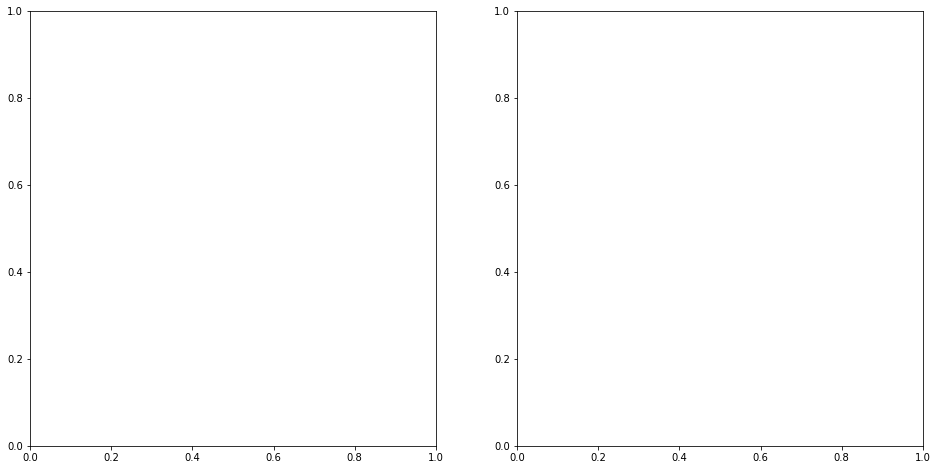

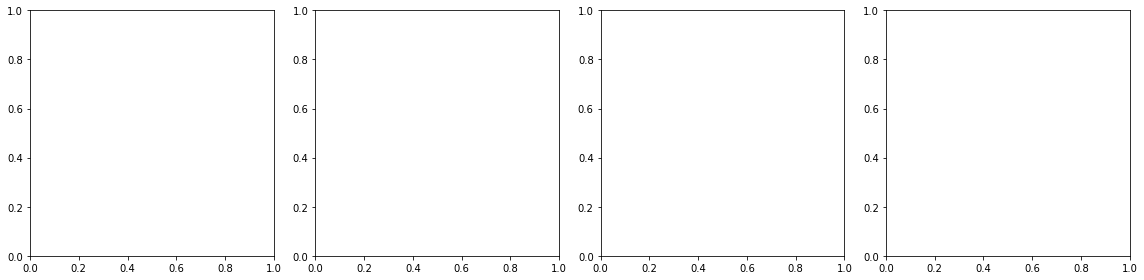

In [54]:
# 6. Plot
## Figure 1 ##
fig1, ax1 = plt.subplots(1, 2, figsize=(NUM_CLOSEST*4, NUM_CLOSEST*2))

# TODO: Plot sketch

# TODO: Plot sketch with attention map
heat_map = sketch_attention.squeeze() # Remove unecessary dimension from the heat map


## Figure 2 ##
fig2, ax2 = plt.subplots(1, NUM_CLOSEST, figsize=(NUM_CLOSEST*4,4))

# TODO: Plot the NUM_CLOSEST images

plt.tight_layout()
plt.show()

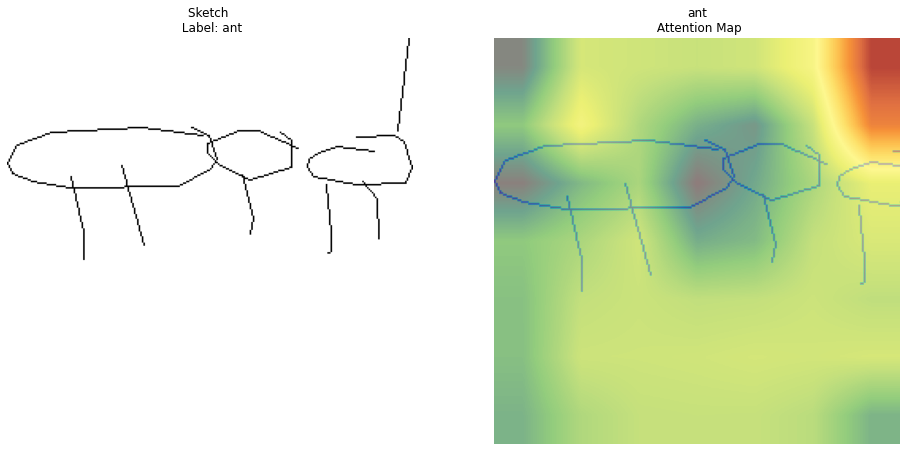

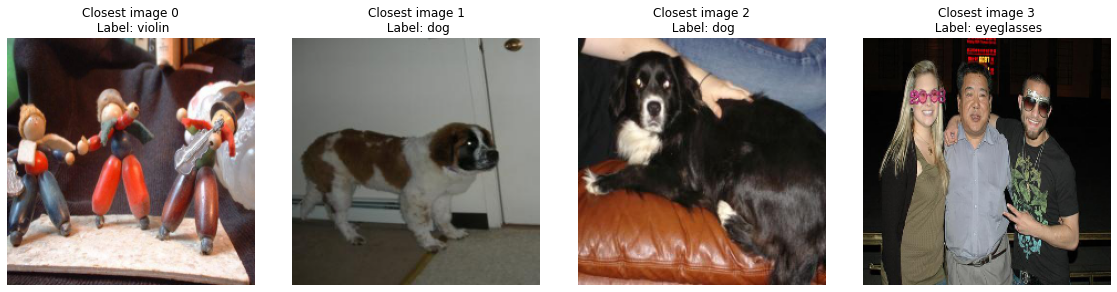

In [55]:
# 6. Solution
fig1, ax1 = plt.subplots(1, 2, figsize=(NUM_CLOSEST*4,NUM_CLOSEST*2))

## Figure 1 ##
# Plot sketch and attention map
sk = plt.imread(sketch_fname)
ax1[0].imshow(sk, cmap="gray")
ax1[0].set(title="Sketch \n Label: " + sketch_fname.split("/")[-2])
ax1[0].axis("off")

# We remove unecessary dimension from the heat map for the plot
heat_map = sketch_attention.squeeze()
ax1[1].imshow(sk)
ax1[1].imshow(255 * heat_map, alpha=0.7, cmap="Spectral_r")
ax1[1].set(title=sketch_fname.split("/")[-2] + "\n Attention Map")
ax1[1].axis("off")

## Figure 2 ##
fig2, ax2 = plt.subplots(1, NUM_CLOSEST, figsize=(NUM_CLOSEST*4,4))
for i in range(NUM_CLOSEST):
    ax2[i].imshow(closest_images[i])
    ax2[i].set(title='Closest image ' + str(i) + '\n Label: ' + closest_labels[i])
    ax2[i].axis('off')

#plt.subplots_adjust(wspace=0.25, hspace=-0.35)
plt.tight_layout()
plt.show()